***importing packages and libraries***

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import RandomContrast, RandomZoom
from tensorflow.keras.utils import pad_sequences
import pathlib as pl
import xml.etree.ElementTree as ET
from configs import Configs 
import os
from html import unescape
%run "tester_functions.ipynb"

In [15]:
def pre_process_image(image, target_height, target_width):
    # Load image
    if isinstance(image, str):
        # If image is a file path, read and decode it
        image = tf.io.read_file(image)
        image = tf.image.decode_image(image, channels=1)  # Decode to grayscale

    # Resize image
    image_resized = tf.image.resize_with_pad(image, target_height, target_width)

    # Convert image to float32 and normalize to [0, 1]
    n_image = tf.image.convert_image_dtype(image_resized, tf.float32)

    return n_image

In [16]:
# a function to seperate the forms imges computer text written parts from the hand written parts
# important as label would need to be doubled to train both parts and other training complications
# the name portion is also needs to be removed as their is not training data on the text
def forms_text_seporator(form_path, HW_bounding_box):
    # read file in based on file path
    image = tf.io.read_file(form_path)
    image = tf.io.decode_image(image, channels=1) #decode image to grayscale
    # configs for dimensions
    configs = Configs()
    # bouding box in the convention [y1, x1, y2, x2]
    CW_bounding_box = [0, 0, HW_bounding_box[0] , configs.form_width ]
    # crop original form image to just handwritten (hence HW) part using correct bounding box
    HW_cropped_image = tf.image.crop_to_bounding_box(
        image, 
        HW_bounding_box[0],
        HW_bounding_box[1],
        HW_bounding_box[2] - HW_bounding_box[0],
        HW_bounding_box[3] - HW_bounding_box[1]
    )
    # crop original form image to just computer wirtten (hence CW) part using correct bounding box 
    CW_cropped_image = tf.image.crop_to_bounding_box(
        image, 
        CW_bounding_box[0],
        CW_bounding_box[1],
        CW_bounding_box[2],
        CW_bounding_box[3]
    )
    return HW_cropped_image, CW_cropped_image

In [17]:
def build_augmentation_model():
    augmentation_model = tf.keras.Sequential([
        RandomContrast(factor=0.5),
        RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1), fill_mode='constant', fill_value=1.0)     
    ])
    return augmentation_model

def random_pad(image, max_padding):
    if isinstance(image, str):
        # If image is a file path, read and decode it
        image = tf.io.read_file(image)
        image = tf.image.decode_image(image, channels=1)
        
    elif isinstance(image, tf.Tensor):
        # If it's a tensor, ensure it's 3D and uint8
        if len(tf.shape(image)) == 4:
            image = tf.squeeze(image, axis=0)  # Remove batch dimension if present
        if image.dtype != tf.uint8:
            image = tf.cast(tf.clip_by_value(image * 255, 0, 255), tf.uint8)
    else:
        raise ValueError("Input must be a tensor or a file path string")

    # Ensure image is a 3D tensor (height, width, channels)
    if len(tf.shape(image)) == 2:
        image = tf.expand_dims(image, -1)

    # Generate random padding values
    pad_top = tf.random.uniform([], minval=max_padding // 4, maxval=max_padding, dtype=tf.int32)
    pad_bottom = tf.random.uniform([], minval=max_padding // 4, maxval=max_padding, dtype=tf.int32)
    pad_left = tf.random.uniform([], minval=max_padding // 4, maxval=max_padding, dtype=tf.int32)
    pad_right = tf.random.uniform([], minval=max_padding // 4, maxval=max_padding, dtype=tf.int32)
    
    # Create padding tensor to outline how to pad
    paddings = [[pad_top, pad_bottom], [pad_left, pad_right], [0, 0]]
    # Pad the image
    padded_image = tf.pad(image, paddings, mode='CONSTANT',  constant_values=255)

    return padded_image

# randomly decide how much to pad form HW or CW images 
def form_pad_val_gen():
    return tf.random.uniform([], minval=100, maxval=250, dtype=tf.int32)
# randomly decide how much to pad line images
def line_pad_val_gen():
    return tf.random.uniform([], minval=20, maxval=70, dtype=tf.int32)


In [18]:
#a function to update the form croping bouding box based on new data from new line
def form_crop_bouding_box_updater(current_bounding_box, line, line_num, total_lin_num):
    # current bounding box is the dimensions of the current word adjusted
    words = line.findall('word')
    for word in words:
        chars = word.findall('cmp')
        for char in chars:
            # first x coord
            x_val = int(char.get('x'))
            if current_bounding_box[1] == 0:
                current_bounding_box[1] = x_val
            elif current_bounding_box[1] > x_val:
                current_bounding_box[1] = x_val
            #  second x coord 
            if current_bounding_box[3] < x_val:
                current_bounding_box[3] = x_val
            # handling y coords cases
            y_val = int(char.get('y'))
            if line_num == 0:
                if current_bounding_box[0] == 0:
                    current_bounding_box[0] = y_val
                elif current_bounding_box[0] > y_val:
                    current_bounding_box[0] = y_val
            elif line_num == total_lin_num:
                if current_bounding_box[2] == 0:
                    current_bounding_box[2] = y_val
                elif current_bounding_box[2] < y_val:
                    current_bounding_box[2] = y_val
    return current_bounding_box


In [19]:
# TODO set appropriate defult image heights and width
def data_preparator(X_image_paths, Y_image_path , data_length = 1000 , image_target_height = 512, image_target_width = 1024, augmentation_probability = 0.35):
    # directory containing labels for training data
    label_dir = pl.Path(Y_image_path)
    # get configs
    configs = Configs()
    # forms and lines paths
    forms_path = X_image_paths[0]
    lines_path = X_image_paths[1]
    # training example and label data X and Y
    X = []
    Y = []
    # keep track of the number files are being added to the data batch
    data_counter = 0
    # keep track of length of longest sequence
    longest_seq_len = 0
    # data augmentor
    augmentation_model = build_augmentation_model()

    for XML_path in label_dir.iterdir():
        if data_counter >= data_length:
            break
        # get XML root element 
        root = ET.parse(str(XML_path)).getroot()
        # a lines in the XML file
        all_line_ele = root.find('handwritten-part')
        lines = all_line_ele.findall('line')
        # get bounding boxes for handwritten part 
        # bouding box in the convention [y1, x1, y2, x2]
        form_crop_bounding_box = [0] * 4
        form_full_text = '' # will be added onto this string 
        line_counter = 0
        line_nums = len(lines) - 1 # the number of lines
        # sub foilder for form that contains the lines for that form
        subf_path = root.get('id')

        # for lines
        for line in lines:
            
            line_text = line.get('text')
            sequence = []
            # remove HTML chars and replace with just their  correpsonding chars 
            line_text = unescape(line_text)
            # create a sequence label int's for current line using mapped chars and line text 
            for char in line_text:
                sequence.append(configs.char_to_index_map[char])
    
            # append to sequence data as a numpy array with data type of int32
            Y.append(np.array(sequence, dtype=np.int32))

            form_full_text += f' {line_text}'

            # image path in the subfolder
            image_subf_path = line.get('id')
            # sulber folder name (is the first 3 chars)
            subf_name = image_subf_path[:3]
            
            full_line_image_path = f'{lines_path}/{subf_name}/{subf_path}/{image_subf_path}.png'
            #process the image 
            line_image = random_pad(full_line_image_path, line_pad_val_gen())
            line_image = pre_process_image(line_image, image_target_height, image_target_width)
            # randomly with a chosen probability augment
            if np.random.rand() < augmentation_probability:
                line_image = augmentation_model(line_image)
                
            X.append(line_image)
            data_counter += 1
            
            form_crop_bounding_box = form_crop_bouding_box_updater(
                form_crop_bounding_box,
                line,
                line_counter,
                line_nums
            )
            line_counter += 1
        
        HW_sequence = []
        CW_sequence = []
        # add the extra text found in CW images
        CW_extra_text = f'Sentence Database {subf_path}'
        # create a sequence label int's for current line using mapped chars and line text
        # for main text 
        for char in form_full_text:
            HW_sequence.append(configs.char_to_index_map[char])

        for char in CW_extra_text:
            CW_sequence.append(configs.char_to_index_map[char])

        # append to sequence data as a numpy array with data type of int32
        np_sequence = np.array(HW_sequence, dtype=np.int32) 
        CW_np_extra_sequence = np.array(CW_sequence, dtype=np.int32)
        # add sequences to sequence list Y
        Y.append(np_sequence)
        Y.append(np.concatenate((CW_np_extra_sequence, np_sequence)))
        # form image path
        full_form_image_path = f'{forms_path}/{subf_path}.png'
        # crop the image in 2 parts and return images contain the HW and CW portions
        CW_cropped_form_image, HW_cropped_form_image = forms_text_seporator(
            full_form_image_path, 
            form_crop_bounding_box
        )
        # randomly pad all form image for richer training data
        CW_form_image = random_pad(CW_cropped_form_image, form_pad_val_gen())
        HW_form_image = random_pad(HW_cropped_form_image, form_pad_val_gen())

        CW_form_image = pre_process_image(CW_form_image, image_target_height, image_target_width)
        HW_form_image = pre_process_image(HW_form_image, image_target_height, image_target_width)

        if np.random.rand() <= augmentation_probability:
            CW_form_image = augmentation_model(CW_form_image)
        if np.random.rand() <= augmentation_probability:
            HW_form_image = augmentation_model(HW_form_image)
            
        X.append(HW_form_image)
        X.append(CW_form_image)
        
        data_counter += 2
    Y_padded = pad_sequences(Y, dtype='int32', padding = 'post', truncating='post') 

    return np.array(X[:data_length]), Y_padded[:data_length]



In [20]:
configs = Configs()
X, Y = data_preparator(configs.image_paths, configs.label_path, data_length = 100, augmentation_probability=0.4 )

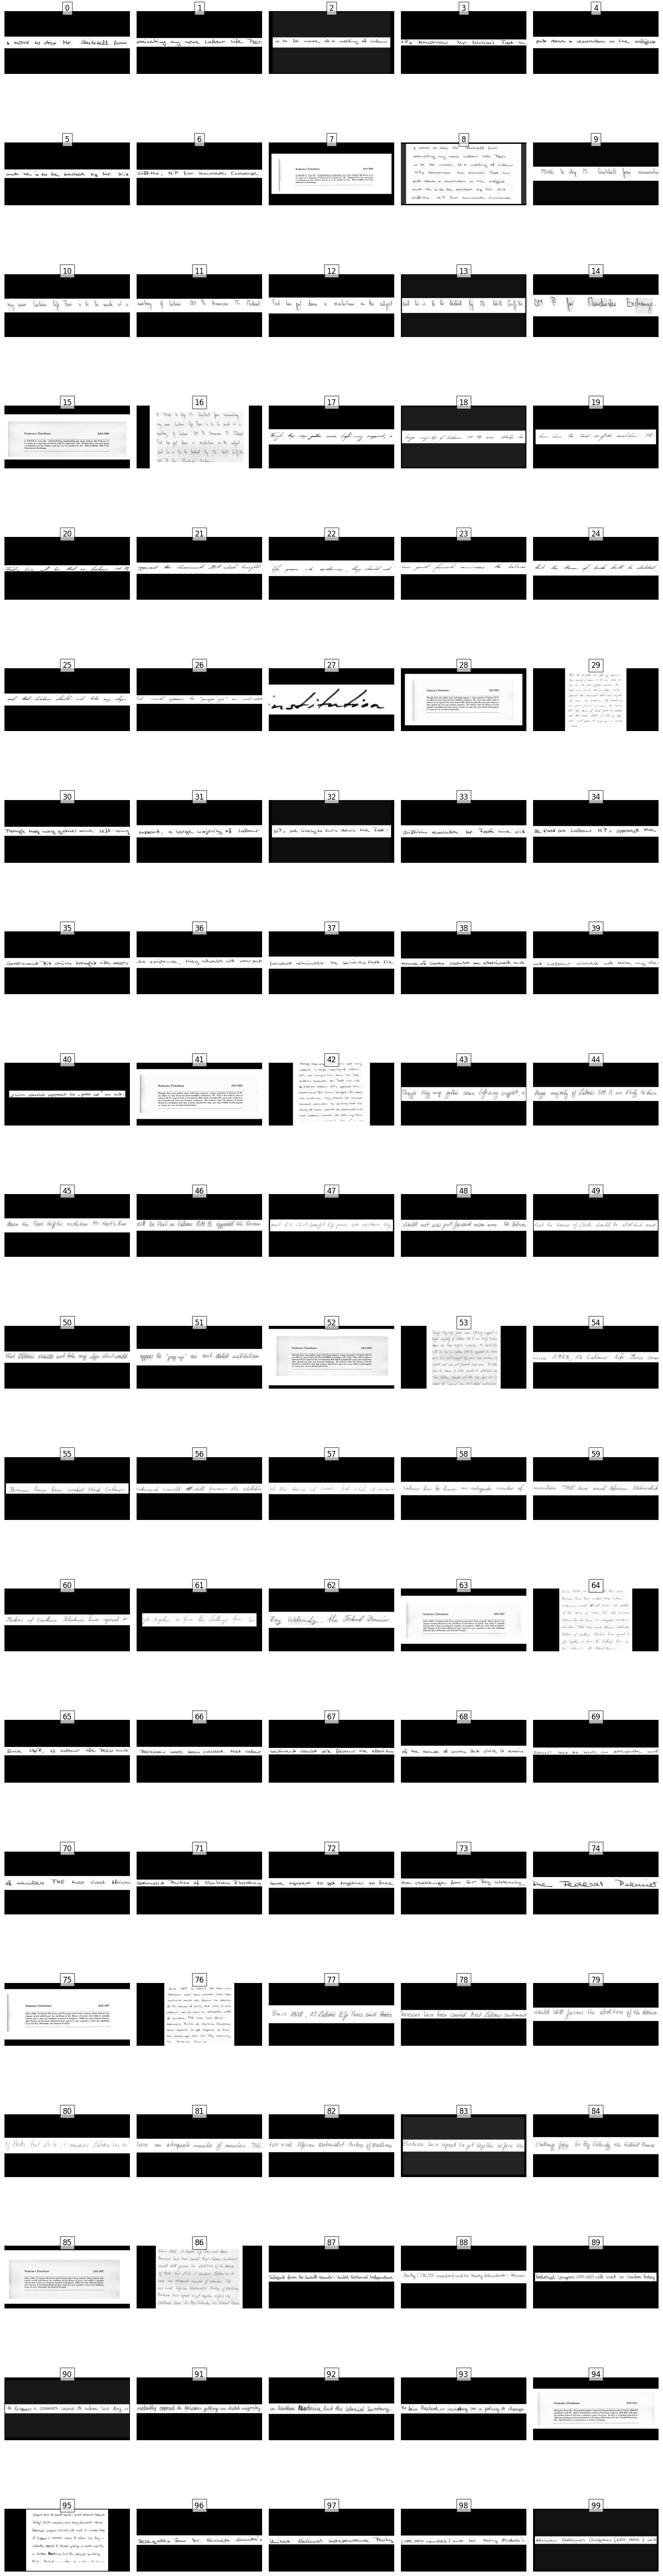

In [21]:
inpute_batch_displayer(X)